# Simulating DSA-200 Images (RCP-like output)

From tyrones_stuff, simulate a very large image, e.g.:

`python sky_model.py --first ~/catalogs/first/first_14dec17.fits -o test_first.fits`

or as Viviana did it for 400 sq deg image:

`python sky_model_wide_dsa.py --first /safepool/vrosero/TRECs/catalogs/trecs/wide_dsa/catalog_first_400sqdeg.fits --agn /safepool/vrosero/TRECs/catalogs/trecs/wide_dsa/catalog_trecs_agn_400sqdeg.fits --sfg /safepool/vrosero/TRECs/catalogs/trecs/wide_dsa/catalog_trecs_sfg_400sqdeg.fits  -o /safepool/vrosero/TRECs/images/first_trecs_400sqdeg_skymodel3.fits --npix 81920 --extent 10`

Details at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf.

TODO: add more sources and make larger area. be sure to set npix to produce correct pixel scale

The simulation process will apply image-plane modifications as they are applied by propagation and measurement (going "forward").
1. apply ionospheric screen
2. apply primary beam and cut out 16k x 16k field (~10 sq deg)
3. add noise
4. convolve with PSF

Then iterate over new screens and pointing directions to create a sequence of measurements of a "tile" (e.g., 5x5).a

## Setup

In [1]:
import os.path
import sys
from scipy.interpolate import RBFInterpolator, CloughTocher2DInterpolator, griddata

from multiprocess import Pool
from typing import Literal, Tuple, Union
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.wcs as wcs
from astropy.io import fits

import numpy as np
from scipy.ndimage import zoom
from jax.scipy.signal import convolve
import jax.numpy as jnp
from jaxtyping import Array

import pandas as pd
import h5py

In [2]:
from data import fits_image
from flow import Flow
from util import indices, rescale_quantile, gaussian_filter, match_histograms
from interactive import toggle_images, plot_image, sequence_images

import cv2

In [3]:
def compute_offsets(dxmodel, dymodel):
    # compute each row separately
    def calc_row(r):
        # all indices with row r
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()  
        xy[:, 0] = r
        row_offsets = np.stack((dxmodel(xy), dymodel(xy)), axis=-1)
        return row_offsets
    
    # Naive multiprocessing (computing each row separately):
    # Note: while this should be extremely parallelizable , something (likely the GIL)
    # is preventing us from achieving optimal performance. This seems to take about 3
    # minutes with multiprocessing (64 cores) and 4.5 minutes without. Thus, Amdahl's
    # law tells us that only about 25% of this task is parallelizable (though it
    # should be closer to 100%).
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(calc_row, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
        return res

    results = go()
    return np.concatenate(results)

def compute_interpolation(interp):
    def g(r):
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()
        xy[:, 0] = r
        return interp(xy)
    
    # naive multiprocessing, see above
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(g, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
                
        return res

    results = go()
    interp_img = np.stack(results, axis=0)
    return interp_img


In [4]:
def reference_sources_nvss(catalog, min_flux=270) -> Tuple[SkyCoord, Array]:
    nvss = pd.read_csv(catalog, sep=r"\s+")
    sorted_nvss = nvss.sort_values(by=["f"])

    # cut off refernce sources below a certain flux density
    sorted_nvss = sorted_nvss[sorted_nvss["f"] >= min_flux]

    # get coordinates of each reference source
    nvss_orig = sorted_nvss[["rah", "ram", "ras", "dd", "dm", "ds"]].to_numpy()

    # get flux of each reference source in Jy
    fluxes = sorted_nvss[["f"]].to_numpy().squeeze() / 1000

    # manually convert HMS:DMS into degrees
    nvss_ra = (
        15 * nvss_orig[:, 0]
        + (15 / 60) * nvss_orig[:, 1]
        + (15 / 3600) * nvss_orig[:, 2]
    )
    nvss_dec = (
        nvss_orig[:, 3] + (1 / 60) * nvss_orig[:, 4] + (1 / 3600) * nvss_orig[:, 5]
    )

    positions = np.stack((nvss_ra, nvss_dec), axis=-1)

    return SkyCoord(positions, unit=(u.deg, u.deg)), jnp.array(fluxes)

In [5]:
def gkern(l=5, sig=1.0):
    """\
    Creates gaussian kernel with side length `l` and a sigma of `sig`.
    Reaches a maximum of 1 at its center value
    """
    ax = jnp.linspace(-(l - 1) / 2.0, (l - 1) / 2.0, l)
    gauss = jnp.exp(-0.5 * jnp.square(ax) / jnp.square(sig))
    kernel = jnp.outer(gauss, gauss)
    return kernel / kernel.max()

In [6]:
def pbmult(img, center, width):
    """ Multiply img by Gaussian primary beam centered at center with width and return entire image.
    width in units of pixels
    """
    size = len(img)
    pb_kernel = gkern(2*size, width)
    return img*pb_kernel[size-center[1]:2*size-center[1], size-center[0]:2*size-center[0]]

In [7]:
import astropy.coordinates as ac
import astropy.units as au
import numpy as np
import pylab as plt


def fibonacci_celestial_sphere(n: int) -> ac.ICRS:
    """
    Generates 'n' points on the surface of a sphere using the Fibonacci sphere algorithm.

    Args:
        n (int): Number of points to generate.

    Returns:
        lon (jnp.ndarray): Array of longitudes in radians.
        lat (jnp.ndarray): Array of latitudes in radians.
    """
    # Golden angle in radians
    golden_angle = np.pi * (3.0 - np.sqrt(5.0))  # Approximately 2.39996 radians

    # Indices from 0 to n-1
    indices = np.arange(n)

    # Compute y coordinates (latitude component)
    y = 1 - (2 * indices) / (n - 1)  # y ranges from 1 to -1

    # Compute latitude in radians
    lat = np.arcsin(y)

    # Compute longitude in radians
    theta = golden_angle * indices
    lon = theta % (2 * np.pi)  # Ensure longitude is within [0, 2π)

    return ac.ICRS(lon * au.rad, lat * au.rad)

## 1. Apply primary beam

In [8]:
# Details on simulation at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf
#input_image = '/home/claw/code/tyrones_stuff/test_first_2048.fits'  # toy image at 1350 MHz and FIRST catalog
input_image = '/safepool/vrosero/TRECs/images/skymodel3/first_trecs_400sqdeg_skymodel3.fits'

# actual:
# - 5x5 field hexagonal mosaic
# - separations should scale with PB FWHM of 3.06 deg (at 1.35 GHz) (Jonas has model with HWHM~1.125 at 2 GHz)
# - 2 deg center-to-center separation (2/3 of PB FWHM) with equilateral triangle separations
# - mosaic should cover 1x field width outside edge

In [9]:
WORKING_DIR = '/safepool/claw/images/'
hdu = fits.open(input_image)[0]
image = hdu.data.squeeze()
hdr = hdu.header
imwcs = wcs.WCS(hdr, naxis=2)
IMAGE_SIZE = image.shape[0]

In [10]:
pixelscale = 20*3600/IMAGE_SIZE  # arcsec/pixel
CPU_COUNT = 4
print(f'Image size: {IMAGE_SIZE} and scale {pixelscale}"/pixel')

# primary beam model specs
pbim_extent = np.radians(10)
pbim_npix = 4096
pbim_pixelscale = 3600*np.degrees(pbim_extent)/pbim_npix
undersample = pbim_pixelscale/pixelscale
print(f'PB image size: {pbim_npix} and scale {pbim_pixelscale}"/pixel')

Image size: 81920 and scale 0.87890625"/pixel
PB image size: 4096 and scale 8.7890625"/pixel


In [11]:
# From Josh: fibonacci_celestial_sphere(n=9000)
# Produces set of pointings wtih typical separation of 2.0 deg (2/3 of FWHM)
# Here are central 25 pointings (all within 6 deg of (RA, Dec) = (0, 0)) in units of degrees

pts_all = fibonacci_celestial_sphere(n=9000)
center = ac.SkyCoord(0, 0, unit="deg")

In [12]:
# typical sep of nearest field (deg)
print(f'{np.median([sorted(pts_all.separation(pt).value)[1] for pt in pts_all[3000:3050]])} deg median separation')

theta_p = 3.1  # primary beam FWHM at 1.35 GHz
width = theta_p*3600/2.35  # 3.1deg width as gaussian sigma in units of arcsec
print(f'nominal pb fwhm = {width*2.35/3600:.1f} deg or {int(width*2.35/pixelscale)} pix')

2.085390009496056 deg median separation
nominal pb fwhm = 3.1 deg or 12697 pix


In [13]:
pts = []
fields = {}
for i in range(len(pts_all)):
#    if pts_all[i].separation(center).value < 6:
    x, y = imwcs.all_world2pix(pts_all[i].ra.value, pts_all[i].dec.value, 1)
#    print(x, y, IMAGE_SIZE, np.degrees(pbim_extent)/2*3600/pixelscale)
#    print(x > int(np.degrees(pbim_extent)/2*3600/pixelscale), (y > int(np.degrees(pbim_extent)/2*3600/pixelscale)), (x < IMAGE_SIZE-int(np.degrees(pbim_extent)/2*3600/pixelscale)), (y < IMAGE_SIZE-int(np.degrees(pbim_extent)/2*3600/pixelscale)))
    if (x > int(np.degrees(pbim_extent)/2*3600/pixelscale)) and (y > int(np.degrees(pbim_extent)/2*3600/pixelscale)) and (x < IMAGE_SIZE-int(np.degrees(pbim_extent)/2*3600/pixelscale)) and (y < IMAGE_SIZE-int(np.degrees(pbim_extent)/2*3600/pixelscale)):
        print(x,y)
        fields[os.path.basename(input_image).replace(".fits", f"_sub{i}.fits")] = (int(x), int(y))

53059.483748187595 60440.89611351615
21799.595533506785 59345.584685446986
41117.328164819606 57572.22332571594
60454.758682881555 55798.86196598486
29153.94646130379 54703.55053791564
48516.22639596204 52930.189178184606
36541.888656636154 50061.51639038432
55919.58542714118 48288.155030653295
24568.370637175576 47192.84360258415
43947.34270675831 45419.48224285312
31961.291157344775 42550.80945505283
51354.220622724635 40777.44809532179
39368.68657342331 37908.77530752156
58746.44499406773 36135.41394779053
27391.35174790628 35040.102519721295
46774.47931658564 33266.74115999023
34796.079735574574 30398.068372190006
54162.58588507827 28624.70701245898
22847.881791610525 27529.39558438976
42196.170847396104 25756.034224658724
30245.365610618464 22887.361436858453
49575.51178076241 21114.000077127454


In [14]:
len(fields)

22

In [15]:
file_path = '/fastpool/claw/images/DSA2000-beam-wShieldSolidCylinder600mm.h5'
with h5py.File(file_path, 'r') as f:
    freq_Hz = f['freq_Hz'][:]
    theta_pts = f['theta_pts'][:]
    phi_pts = f['phi_pts'][:]
    
    # X polarization E-fields
    X_pol_etheta = f['X_pol_Efields/etheta'][:]
    X_pol_ephi = f['X_pol_Efields/ephi'][:]
    
    # Y polarization E-fields
    Y_pol_etheta = f['Y_pol_Efields/etheta'][:]
    Y_pol_ephi = f['Y_pol_Efields/ephi'][:]
    
    # Freq idx for 1.35 GHz
    freq_idx = 1
    selected_freq = freq_Hz[freq_idx]
    
    # Compute the total E-field for X and Y polarizations
    E_tot_X = np.abs(X_pol_etheta[freq_idx, :, :])**2 + np.abs(X_pol_ephi[freq_idx, :, :])**2
    E_tot_Y = np.abs(Y_pol_etheta[freq_idx, :, :])**2 + np.abs(Y_pol_ephi[freq_idx, :, :])**2

theta_radians = np.deg2rad(theta_pts)
phi_radians = np.deg2rad(phi_pts)

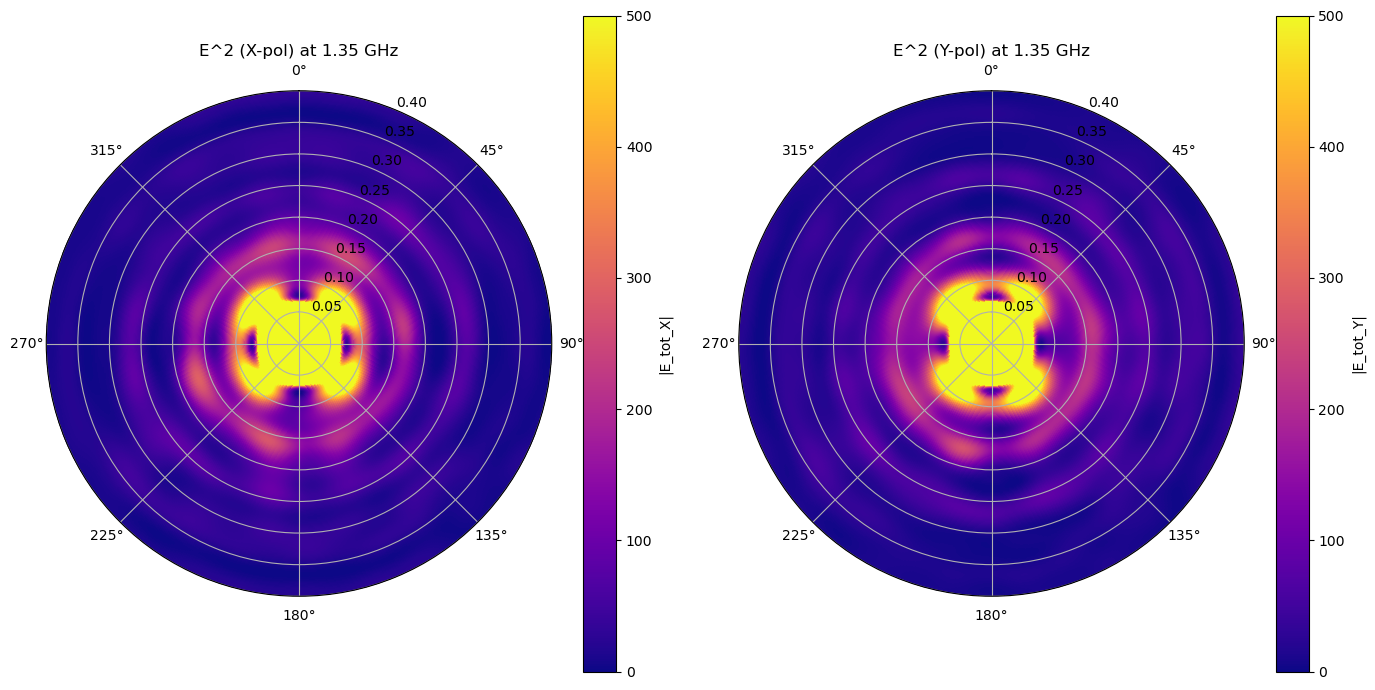

In [16]:
Theta, Phi = np.meshgrid(theta_radians, phi_radians)

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 7))

c1 = ax1.pcolormesh(Phi, Theta, E_tot_X.T, vmin = 0, vmax = 500, shading='auto', cmap='plasma')
ax1.set_title(f'E^2 (X-pol) at {selected_freq} GHz')
ax1.set_theta_zero_location('N')  # Set 0 degrees at the top
ax1.set_theta_direction(-1)  # Set angles to increase clockwise
fig.colorbar(c1, ax=ax1, label='|E_tot_X|')

# Zoom in on theta
ax1.set_ylim(0, 0.4)

# Plot for Y polarization in polar coordinates
c2 = ax2.pcolormesh(Phi, Theta, E_tot_Y.T, vmin = 0, vmax = 500, shading='auto', cmap='plasma')
ax2.set_title(f'E^2 (Y-pol) at {selected_freq} GHz')
ax2.set_theta_zero_location('N')  # Set 0 degrees at the top
ax2.set_theta_direction(-1)  # Set angles to increase clockwise
fig.colorbar(c2, ax=ax2, label='|E_tot_Y|')

# Zoom in on theta
ax2.set_ylim(0, 0.4)

plt.tight_layout()
plt.savefig('/fastpool/claw/images/DSA2000-beam-wShieldSolidCylinder600mm.png')

In [17]:
def polar_to_cartesian(phi, theta):
    x = theta * jnp.cos(phi)
    y = theta * jnp.sin(phi)
    return x, y

# does not work. using scipy instead
def find_nearest_indices(array1, value1, array2, value2):
    # Flatten the first array and find the nearest index for value1
    flat_array1 = array1.flatten()[None, :]
    flat_array2 = array2.flatten()[None, :]
    value1 = jnp.array(value1)[:, None]
    value2 = jnp.array(value2)[:, None]
    nearest_index_flat = jnp.argmin(jnp.abs(jnp.subtract(flat_array1, value1)) + jnp.abs(jnp.subtract(flat_array2, value2)), axis=1)
    nearest_index_2d = jnp.unravel_index(nearest_index_flat, array2.shape)
    return nearest_index_2d

def find_nearest_dist(array1, value1, array2, value2):
    # Flatten the first array and find the nearest index for value1
    flat_array1 = array1.flatten()[None, :]
    flat_array2 = array2.flatten()[None, :]
    value1 = jnp.array(value1)[:, None]
    value2 = jnp.array(value2)[:, None]
    return jnp.min(jnp.abs(jnp.subtract(flat_array1, value1)) + jnp.abs(jnp.subtract(flat_array2, value2)), axis=1)

In [18]:
#X0, Y0 = np.radians(np.mgrid[-5.12:5.12:0.01, -5.12:5.12:0.01])
#Y0, X0 = np.radians(np.mgrid[2:90:0.01, 2:90:0.01])  # create final grid coordinates

grid_extent = np.linspace(-pbim_extent/2, pbim_extent/2, pbim_npix)
X0, Y0 = np.meshgrid(grid_extent, grid_extent)

In [19]:
X, Y = polar_to_cartesian(Phi, Theta)
print(Theta.shape, X.shape, E_tot_X.shape, X0.shape)
#plt.imshow(P0, origin='lower')
#plt.colorbar()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(3601, 1801) (3601, 1801) (1801, 3601) (4096, 4096)


In [20]:
# this does not work. wrapping issue?
#i0, i1 = find_nearest_indices(X, jnp.array(X0.flatten()), Y, jnp.array(Y0.flatten()))
#dd = find_nearest_dist(X, jnp.array(X0.flatten()), Y, jnp.array(Y0.flatten()))

In [21]:
overwrite = False

# this does not work. wrapping issue?
#pbim_XY = (E_tot_X[i1, i0] + E_tot_Y[i1, i0]).reshape(X0.shape)

# this works
if not os.path.exists(os.path.join(WORKING_DIR, 'DSA2000-beam-wShieldSolidCylinder600mm_XY.fits')) or overwrite:
    pbim_XY = griddata((X.ravel(), Y.ravel()), E_tot_X.T.ravel()+E_tot_Y.T.ravel(), (X0, Y0), method='nearest')

    _, wpsf = fits_image('/fastpool/data/W-GC-8000chan-briggs09-psf.fits')
    hpsf = wpsf.to_header()
    hpsf["CRPIX1"] = pbim_XY.shape[0]//2
    hpsf["CRPIX2"] = pbim_XY.shape[0]//2
    hpsf["CDELT1"] = -pbim_pixelscale/3600
    hpsf["CDELT2"] = pbim_pixelscale/3600
    hpsf["CRPIX3"] = 1.
    hpsf["CRVAL3"] = 1350.
    hpsf["CDELT3"] = 1.0
    hpsf["CTYPE3"] = "FREQ"
    hpsf["CUNIT3"] = "MHz"
    hpsf["CTYPE4"] = "STOKES"
    hpsf["CRPIX4"] = 1.
    hpsf["CRVAL4"] = 1.
    hpsf["CDELT4"] = 1.0
    hpsf["CUNIT4"] = ""
    fits.writeto(os.path.join(WORKING_DIR, 'DSA2000-beam-wShieldSolidCylinder600mm_XY.fits'), pbim_XY/pbim_XY.max(), header=hpsf, overwrite=True)
else:
    pbim_XY, wpsf = fits_image(os.path.join(WORKING_DIR, 'DSA2000-beam-wShieldSolidCylinder600mm_XY.fits'))

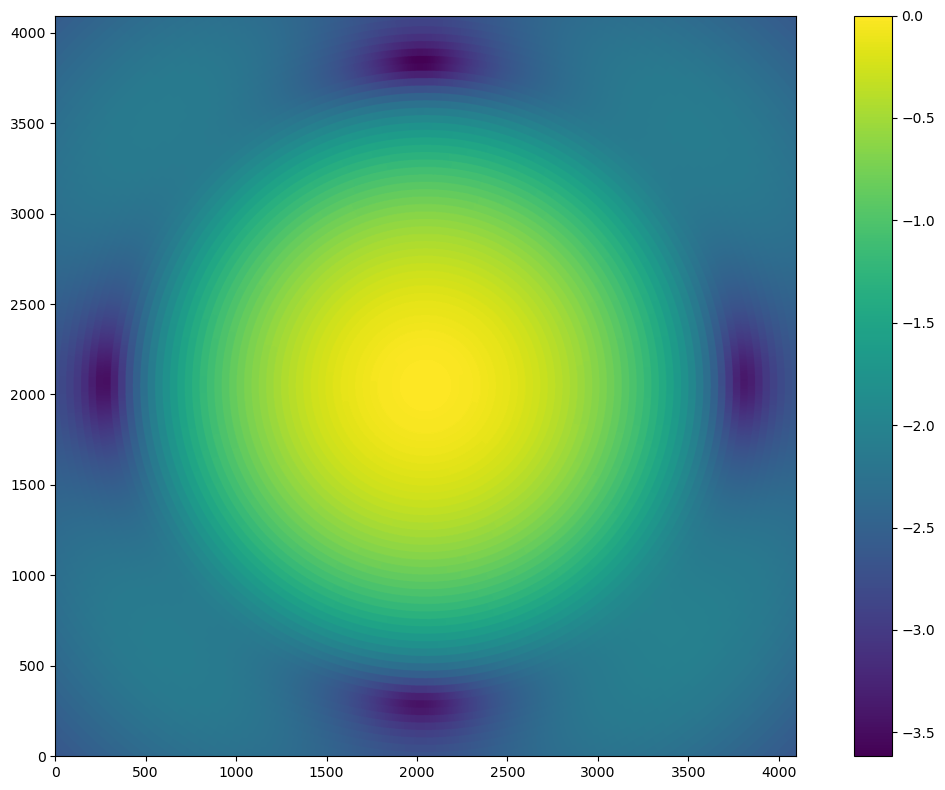

In [22]:
fig, (ax0) = plt.subplots(1, 1, figsize=(12,8))
im = ax0.imshow(np.log10(pbim_XY/pbim_XY.max()), origin='lower')
fig.colorbar(im)
fig.tight_layout()

## Beam application

In [23]:
size = pbim_XY.shape[0]*int(pbim_pixelscale//pixelscale)  # int(np.degrees(pbim_extent)/2*3600/pixelscale)
pbim_XY_exp = zoom(pbim_XY, int(pbim_pixelscale//pixelscale), order=0)

In [24]:
overwrite = False

wcss = fields.copy()

for name, center in fields.items():
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name)):
        print(f'not overwriting {name}')
        continue

    print(os.path.join(WORKING_DIR, name))
    image, w0 = fits_image(input_image)
    output_pbcut = image[center[0]-size//2:center[0]+size//2, center[1]-size//2:center[1]+size//2]*pbim_XY_exp
    output_pbcut = np.expand_dims(np.expand_dims(output_pbcut, 0), 0)  # 4d output

#    image2 = image[center[0]-2*int(width/pixelscale):center[0]+2*int(width/pixelscale),
#                   center[1]-2*int(width/pixelscale):center[1]+2*int(width/pixelscale)]
#    output_pbcut = np.array(pbmult(image2, [len(image2)//2, len(image2)//2], width/pixelscale))
#    output_image = np.expand_dims(np.expand_dims(output_pbcut, 0), 0)

    crval = w0.pixel_to_world(center[1]-size//2, center[0]-size//2)
    w0.wcs.crval = [crval.ra.value, crval.dec.value]
    w0.wcs.crpix = [0, 0]
    hdr = w0.to_header()
    hdr["CRPIX3"] = 1.
    hdr["CRVAL3"] = 1350.
    hdr["CDELT3"] = 1.0
    hdr["CTYPE3"] = "FREQ"
    hdr["CUNIT3"] = "MHz"
    hdr["CTYPE4"] = "STOKES"
    hdr["CRPIX4"] = 1.
    hdr["CRVAL4"] = 1.
    hdr["CDELT4"] = 1.0
    hdr["CUNIT4"] = ""
    wcss[name] = w0
    fits.writeto(f"{os.path.join(WORKING_DIR, os.path.basename(name))}", np.array(output_pbcut), header=hdr, overwrite=overwrite)

/fastpool/claw/images/first_trecs_400sqdeg_skymodel3_sub4126.fits
/fastpool/claw/images/first_trecs_400sqdeg_skymodel3_sub4147.fits
/fastpool/claw/images/first_trecs_400sqdeg_skymodel3_sub4181.fits
/fastpool/claw/images/first_trecs_400sqdeg_skymodel3_sub4215.fits
/fastpool/claw/images/first_trecs_400sqdeg_skymodel3_sub4236.fits


KeyboardInterrupt: 

## 2. Ionosphere (one per field)

## fake a warp screen with random ~PSF scale shifts at NVSS positions


In [28]:
# potential improvement:
# Josh says ionosphere should show coherent shifts across 0.6deg scales
# Neighboring 0.6deg regions being independent (a sequence of fields have independent screens)
# NVSS is 2 mJy sky => 40/deg2 => roughly 1 per 10 arcmin
# Simulated screen is smoothed, so maybe 1/10 arcmin is lower limit and actual screen is likely close to physical value.

In [24]:
catalog = '/fastpool/claw/catalogs/nvss_trim.dat'
positions_xys = fields.copy()


In [28]:
for name, positions_xy in positions_xys.items():
    print(name)
    hdu = fits.open(f"{os.path.join(WORKING_DIR, name)}")[0]
    w = wcs.WCS(header=hdu.header)
    positions, fluxes = reference_sources_nvss(catalog=catalog)
    positions_xy = jnp.stack(wcs.utils.skycoord_to_pixel(positions, w), axis=1)
    fluxes = fluxes[~jnp.isnan(positions_xy).any(axis=1)]
    positions_xys[name] = positions_xy[~jnp.isnan(positions_xy).any(axis=1)]

first_trecs_400sqdeg_skymodel3_sub4126.fits


FileNotFoundError: [Errno 2] No such file or directory: '/safepool/claw/images/first_trecs_400sqdeg_skymodel3_sub4126.fits'

In [23]:
smoothing = 200
neighbors = 3
max_shift = 2
overwrite = False

for name, positions_xy in positions_xys.items():
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name.replace('.fits', 'warped.fits'))):
        print('\tnot overwriting', name.replace('.fits', 'warped.fits'))
        continue
    print(name.replace('.fits', 'warped.fits'))

    hdu = fits.open(f"{os.path.join(WORKING_DIR, name)}")[0]
    image = hdu.data
    hdr = hdu.header
    IMAGE_SIZE = image.shape[2]
    
    # create difference array
    diff = np.random.randint(-max_shift, max_shift+1, size=(len(positions_xy), 2))   
    dxmodel = RBFInterpolator(positions_xy, diff[:, 0], kernel='linear', smoothing=smoothing, neighbors=neighbors)
    dymodel = RBFInterpolator(positions_xy, diff[:, 1], kernel='linear', smoothing=smoothing, neighbors=neighbors)
    offsets = compute_offsets(dxmodel, dymodel).reshape(IMAGE_SIZE, IMAGE_SIZE, 2)  # IMAGE_SIZE^2 x 2
    print('calculating flow')

    stack = []
    for i in range(4):
        fl = Flow(offsets=offsets[IMAGE_SIZE*i//4:IMAGE_SIZE*(i+1)//4])
        stack.append(fl.apply(np.float_(image[0, 0, IMAGE_SIZE*i//4:IMAGE_SIZE*(i+1)//4])))
    output_img = np.expand_dims(np.expand_dims(jnp.concat(stack, axis=0), 0), 0)

    bmaj = 3.3*u.arcsec
    hdr['BUNIT'] = 'Jy/beam'
    hdr['BTYPE'] = 'Intensity'
    hdr['BMAJ'] = bmaj.to(u.deg).value
    hdr['BMIN'] = bmaj.to(u.deg).value
    hdr['BPA'] = 0.0

#    output_img = np.expand_dims(np.expand_dims(output_img, 0), 0)  # 4d output

    plot_image(output_img.squeeze(), vmax=1e-5)
    fits.writeto(os.path.join(WORKING_DIR, os.path.basename(name).replace('.fits', 'warped.fits')),
                 output_img, header=hdr, overwrite=overwrite)

NameError: name 'positions_xys' is not defined

## 3. Make PSF per field

In [29]:
# rotate PSF per field? scipy affine transform (effects of changing projected size and orientation of array)
# save PSF per field

In [34]:
psf_filename = '/fastpool/data/W-GC-8000chan-briggs09-big-psf.fits'
psf_image, psf_wcs = fits_image(psf_filename)
rows, cols = psf_image.shape
print(psf_image.shape)

(32000, 32000)


In [36]:
overwrite = False

psfs = {}
for name, center in fields.items():
    suffix = '_' + name.split('_')[-1]
    newname = os.path.basename(psf_filename).replace('.fits', suffix)
    psfs[name] = newname

    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, newname)):
        print(f'skipping {newname}')
        continue
    else:
        print(f'making {newname}')

    angle = np.random.randint(180) # deg
    scale = np.random.uniform(1, 2) # foreshortening factor from ZA=0-60 deg

    dst = cv2.resize(np.array(psf_image), (int(scale*cols), rows))[:, int((scale-1)*cols)//2:int((scale+1)*cols)//2]   # rescale
    midx, midy = np.where(dst == dst.max())
    M = cv2.getRotationMatrix2D((int(midx[0]), int(midy[0])), angle, 1)
    cols, rows = dst.shape
    dst = cv2.warpAffine(dst, M, (cols, rows))  # rotate
    plot_image(dst, vmax=1e-4)
    fits.writeto(os.path.join(WORKING_DIR, newname), dst, header=psf_wcs.to_header(), overwrite=overwrite)

skipping W-GC-8000chan-briggs09-big-psf_sub4126.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4147.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4181.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4215.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4236.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4270.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4325.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4359.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4380.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4414.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4469.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4503.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4558.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4592.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4613.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4647.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4702.fits
skipping W-GC-8000chan-briggs09-big-psf_sub4736.fits
skipping W-GC-8000chan-briggs09-big-psf_sub475

## 4. Add noise and convolve

In [29]:
noise_sigma = 3e-7  # noise floor is 6x higher in Jy/beam
realbeam = True
overwrite = False

for name, positions_xy in positions_xys.items():
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name.replace('.fits', 'warpednoiseconv2.fits'))):
        print('\tskipping', name)
        continue
    print(name)

    if realbeam:
        psf_filename = psfs[name]  # '/fastpool/data/W-GC-8000chan-briggs09-psf.fits'
        psf_image, psf_wcs = fits_image(os.path.join(WORKING_DIR, psf_filename))
        hdr = psf_wcs.to_header()

        # normalization factor for core of PSF that overlaps input image
#        psf_width = psf_image.squeeze().shape[0]
#        psf_norm = psf_image.squeeze()[psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2,
#                                       psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2].sum()

#        print(psf_norm, psf_width, IMAGE_SIZE)
    else:
        # overload with restoring beam
        psf_image = gkern(l=64, sig=3.3/pixelscale)
#        psf_norm = psf_image.sum()

    hdu = fits.open(os.path.join(WORKING_DIR, os.path.basename(name).replace('.fits', 'warped.fits')))[0]
    image = np.ma.masked_invalid(hdu.data.squeeze())
    image.set_fill_value(0)
    hdr = hdu.header
    noise = np.random.normal(0, noise_sigma, size=image.shape)  # zero mean
    image_noise = image.filled()+noise
    noise_convolved = convolve(image_noise, psf_image, mode="valid", method="fft")

    bmaj = 3.3*u.arcsec
    hdr['BUNIT'] = 'Jy/beam'
    hdr['BTYPE'] = 'Intensity'
    hdr['BMAJ'] = bmaj.to(u.deg).value
    hdr['BMIN'] = bmaj.to(u.deg).value
    hdr['BPA'] = 0.0

    noise_convolved = np.expand_dims(np.expand_dims(noise_convolved, 0), 0)
    fits.writeto(os.path.join(WORKING_DIR, os.path.basename(name).replace('.fits', 'warpednoiseconv2.fits')),
                 noise_convolved, header=hdr, overwrite=overwrite)
    break
#    plot_image(noise_convolved, vmax=1e-5)

first_trecs_400sqdeg_skymodel3_sub4126.fits


## 5. cut (and optionally rescale)